In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [3]:
class EncoderDecoder(nn.Module):
    """
    A stanard Encoder-Decoder architecture.Base fro this and many other models.
    """
    
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        """ Take in and process masked src and target sequences. """
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [4]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [5]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [6]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [7]:
class LayerNorm(nn.Module):
    """ Construct a layernorm model (See citation for details)"""
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [8]:
class SublayerConnection(nn.Module):
    """ 
    A residual connection followed by a layer norm. Note for 
    code simplicity the norm is first as opposed to last .
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        """Apply residual connection to any sublayer with the sanme size. """
        return x + self.dropout(sublayer(self.norm(x)))

每层有两个子层。第一个子层是multi-head self-attention机制，第二层是一个简单的position-wise全连接前馈神经网络。

In [9]:
class EncoderLayer(nn.Module):
    """Encoder is made up of self-attention and feed forward (defined below)"""
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
    
    def forward(self, x, mask):
        """Follow Figure 1 (left) for connection """
        x = self.sublayer[0](x, lambda x : self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

Decoder由6个相同layer堆成

In [38]:
class Decoder(nn.Module):
    """Generic N layer decoder with masking """
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

每个encoder层除了两个子层外，还插入了第三个子层，即在encoder堆的输出上上执行multi-head注意力作用的层。类似于encoder，在每一个子层后面使用残差连接，并紧跟norm

In [11]:
class DecoderLayer(nn.Module):
    """Decoder is made of self-attn, src-attn, and feed forward (defined below)"""
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        """Follow Figure 1 (right) for connections"""
        m = memory
        x = self.sublayer[0](x, lambda x : self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x : self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

修改在decoder层堆中的self-atention 子层，防止位置关注后续位置。masking与使用一个position信息偏移的输出embedding相结合，确保对于position $i$ 的预测仅依赖于小于 $i$ 的position的输出

In [12]:
def subsequent_mask(size):
    """Mask out subsequent positions. """
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

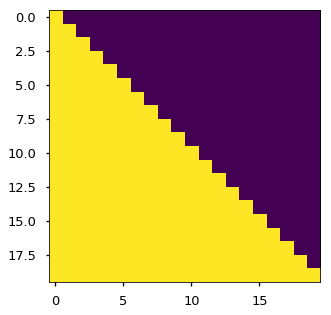

In [13]:
plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(20)[0])
None

## Attention
注意力功能可以看做将一个query和一组key-value对映射到一个output，其中query、keys、values和output都是向量(vector)，输出是values的加权和，其中权重可以通过将query和对应的key输入到一个compatibility function来计算分配给每一个value的权重。

这里的attention其实可以叫做“Scaled Dot-Product Attention”。输入由$d_k$维度的queries和keys组成，values的维度是$d_v$。计算query和所有keys的点乘，然后除以$\sqrt{d_k}$，然后应用softmax函数来获取值的权重。$\sqrt{d_k}$起到调节作用，使得内积不至于太大（太大的话softmax后就非0即1了，不够“soft”了）。

实际计算中，一次计算一组queries的注意力函数，将其组成一个矩阵$Q$, 并且keys和values也分别组成矩阵$K$和$V$。此时，使用如下公式进行计算：
$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

In [14]:
def attention(query, key, value, mask=None, dropout=None):
    """Compute 'Scaled Dot Product Attention ' """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # matmul矩阵相乘
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

最常用的两种注意力实现机制包括： additive attention (cite), and dot-product (multiplicative) attention.
此处的实现是dot-product attention，不过多了$\sqrt{d_k}$。additive attention计算函数使用一个但隐藏层的前馈神经网络。
这两种实现机制在理论上复杂度是相似的，但是dot-product attention速度更快和更节省空间，因为可以使用高度优化的矩阵乘法来实现。

对于小规模values两种机制性能类差不多，但是对于大规模的values上，additive attention 性能优于 dot poduct。
原因分析：猜测可能是对于大规模values，内积会巨幅增长，将softmax函数推入有一个极小梯度的区域，造成性能下降（为了说明为什么内积变大，假设$q和k$ 是独立且平均值为0方差为1的随机变量，那么点乘$q*k = \sum^{d_k}_{i=1}q_ik_i$，其平均值为0，方差为1）为了抵消负面影响，使用$\sqrt{d_k}$来缩放内积

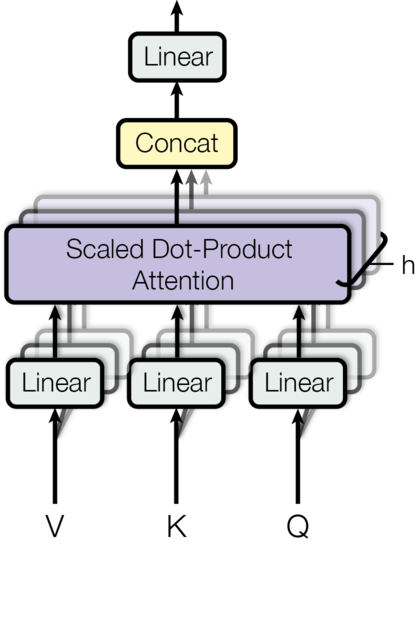

In [15]:
from IPython.display import Image
Image("images/ModalNet-20.png")

Multi-head attention允许模型共同关注在不同位置的来自不同子空间的表示信息，只要一个单独的attention head，平均一下就会抑制上面所说的情况。此时，用公式表示如下：
$MultiHead(Q, K, V) = Concat(head-1, \dots, head_h)W^o$ 

其中$head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)$，$W_i^Q \in \mathcal{R}^{d_model * D_k}, W_i^K \in \mathcal{d_model * d_k}, W_i^V \in \mathcal{d_model*d_v} 并且 W_o \ in \mathcal{R}^{hd_v*d_{model}}$

此处，使用h=8平行的attention层或者heads，对每一层使用$d_k=d_v=d_{model}/h=64$

In [16]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """ Take in model size and numbe of heads """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        """图片ModalNet-20的实现"""
        if mask is not None:
            # 同样的mask应用到所有heads
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1. 批量做linear投影 => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) 
                            for l, x in zip(self.linears, (query, key, value))]
        # 2. 批量应用attention机制在所有的投影向量上
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        
        # 3. 使用view进行“Concat”并且进行最后一层的linear
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### 模型中attention的应用
对于Transformer模型来说，使用三种不同的方式来使用multi-head attention
* 在“encoder-decoder attention”层，queries来自前一个decoder层，并且keys和values来自encoder的输出层。这使得在decoder层里的每一个位置信息对齐输入序列中的所有位置，这模拟了sequence-to-sequence模型中的典型的encoder-decoder注意力机制
* encoder层中包含了self-attention层。在self-attention层中，所有的keys、values和queries都来自同一处，在此例中，来自encoder的前一层。在encoder中的每一个position对齐encoder的前一层的所有position
* decoder层中的self-attention允许每一个position使用decoder的包括这个position在内的所有position。我们需要防止信息流左流来保证其自回归性。我们通过在缩放点乘 attention中使用mask技术（设置为负无穷）应用所有values，这个values是softmax层的输入，其对应非法连接（illegal connections）

## position-wise前馈神经网络
除了子层中的attention，在encoder和decoder的所有层中都包含一个全连接前馈神经网络，它将分别和共同应用于position。其中包括两个两个带有ReLU激活函数的线性变换：
$$FFN(x) = max(0, xW_1 + b_1)W_2 + b_2$$
对于不同的position，使用的线性变换虽然是相同的，但层与层之间的参数是不同的。这其实就是两个大小为1的一维卷积。输入和输出维度都是512，内层维度是2048

In [17]:
class PositionWiseFeedForward(nn.Module):
    """ 
    FFN实现 
    d_model = 512
    d_ff = 2048
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionWiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings和Softmax
这里的Embeddings和传统的序列任务一样，使用训练好的Embedding，将输入token和输出token变成词向量，维度为d_model。
使用常见的线性变换和softmax函数将decoder的输出变为next-token的预测概率。
在我们的模型中，两个embedding层和pre-softmax层共享相同的权重矩阵。
在Embedding层，将$\sqrt{d_{model}}$乘以这些权重。

In [18]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding
因为在此模型中不包含卷积和循环（层），这样的模型并不能捕捉序列的顺序！换句话说，如果将K,V按行打乱顺序（相当于句子中的词序打乱），那么Attention的结果还是一样的。对于时间序列来说，尤其是对于NLP中的任务来说，顺序是很重要的信息，它代表着局部甚至是全局的结构，学习不到顺序信息，那么效果将会大打折扣（比如机器翻译中，有可能只把每个词都翻译出来了，但是不能组织成合理的句子）。为了使模型能够充分利用序列信息，必须为模型注入tokens的相对或绝对信息。为此，加入“position embedding”到encoder和decoder层底部的输入层中。
position embedding和embeddings有相同的维度，都是d_model。所以这两个emebdding可以求和。
对于position embedding，有很多选择，可以参考这篇论文。[点击查看](https://arxiv.org/pdf/1705.03122.pdf)
在此模型中，使用不同频率的正弦和余弦函数：
$$PE_{(pos, 2i)}(p） = sin(pos/10000^{2i/d_{model}})，PE_{(pos, 2i+1)}(p)= cos(pos/10000^{2i/d_{modle}})$$
pos代表position，i代表维度。所以，position编码的每个维度对应正弦曲线。这里的意思是将id为p的位置映射为一个dpos维的位置向量，这个向量的第i个元素的数值就是$PE_i(p)$。波长是从$2\pi到1000*2\pi$的几何级数。
之所以选择这个函数，由于我们有sin(α+β)=sinαcosβ+cosαsinβ以及cos(α+β)=cosαcosβ−sinαsinβ，这表明位置p+k的向量可以表示成位置p的向量的线性变换，这提供了表达相对位置信息的可能性。
对于任何偏移量k，$PE_{pos+k}$ 可以表示为$PE_{pos}$的线性函数。

除此之外，在encoder和decoder中的positional编码中和embeddings求和中都使用了dropout。对于base model，$P_{drop} = 0.1$

In [19]:
class PositionalEncoding(nn.Module):
    """PE函数实现"""
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-(math.log(10000.0)/ d_model)))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)
    

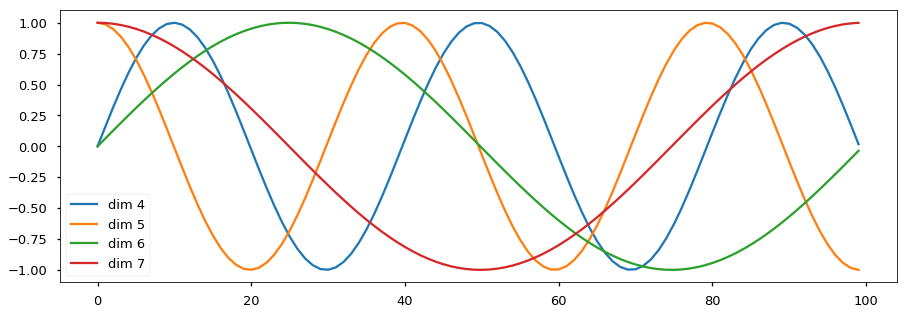

In [20]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d" %p for p in [4, 5, 6, 7]])
None

论文里比较过直接训练出来的位置向量和上述公式计算出来的位置向量，效果是接近的。因此显然我们更乐意使用公式构造的Position Embedding了，因为允许模型扩展到比训练时候序列更长的序列长度。

In [21]:
def make_model(src_vacab, tgt_vocab, N=6, d_model=512, d_ff =2048, h=8, dropout=0.1):
    """ 构建模型"""
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionWiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vacab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )
    
    # !!!import for the work
    # 使用Glorot/ fan_avg初始化参数
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [22]:
tmp_model = make_model(10, 10, 2)

In [23]:
tmp_model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1)
        )
        (feed_forward): PositionWiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropout): Dropout(p=0.1)
          )
          (1): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropo

### 模型训练
首先定义一个包含源句子和目标句子的批处理对象，同事构建masks

### Batches and Masking

In [24]:
class Batch:
    """ 在训练期间使用mask处理数据 """
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        """ 创造一个mask来屏蔽补全词和字典外的词进行屏蔽"""
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

### Training and Loss compute

In [44]:
def run_epoch(data_iter, model, loss_compute):
    """ 标准训练和日志函数 """
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss : %f Tokens per Sec: %f " % (i, loss/ batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

### Training Data and Batching
论文中使用的数据集较大，这里使用的是torchtext函数

In [26]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    """ 保持数据批量增加，并计算toens+padding的总数 """
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
    
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

### Optimizer
使用Adam优化器， 其中$\beta_1 = 0.9, \beta_2 = 0.98, \epsilon = 10^{-1}$

使用如下方式调整学习率：
$$lrate = d_{model}^{-0.5}\cdot \min(step\_num^{-0.5}, step\_num \cdot warmup\_step^{-1.5})$$
先随着训练step线性增加，之后将其与步数的倒数平方根成比例地减小，论文中warmupsteps = 4000

In [27]:
# 这个部分很重要，需要这样设置模型参数

In [28]:
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        """ 更新参数和学习率 """
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        """ lrate 实现"""
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
def get_std_up(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000, 
                   torch.optim.Adam(model.param_groups(), 
                                    lr = 0, betas = (0.9, 0.98), eps = 1e-9))

#### 针对不同模型大小和优化超参数的此模型的曲线示例。

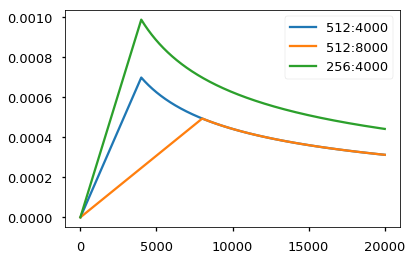

In [29]:
opts = [NoamOpt(512, 1, 4000, None),
       NoamOpt(512, 1, 8000, None),
       NoamOpt(256, 1, 4000, None)]

plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

### Regularization
#### Label Smoothing 标签平滑
论文中训练的时候使用$\epsilon = 0.1$进行标签平滑（[参考论文](https://arxiv.org/abs/1512.00567)），这样会增加复杂性，因为模型学得更加不确定性，但提高了准确性和BLEU分数。

在实际实现时，这里使用KL div loss实现标签平滑。没有使用one-hot目标分布，而是创建了一个分布，对于整个词汇分布表，这个分布含有正确单词度和剩余部分平滑块的置信度

In [30]:
class LabelSmoothing(nn.Module):
    """ 标签平滑实现 """
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
            
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))            

在这里，我们可以看到基于置信度如何将语料分布到单词的示例。

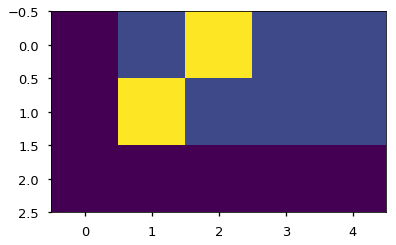

In [31]:
# 标签平滑的例子
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                            [0, 0.2, 0.7, 0.1, 0],
                            [0, 0.2, 0.7, 0.1, 0]])

v = crit(Variable(predict.log()), Variable(torch.LongTensor([2, 1, 0])))
# 展示目标label的期望分布
plt.imshow(crit.true_dist)
None

#### 如果对于一个给定选择非常有信息，标签平滑实际上开始惩罚模型


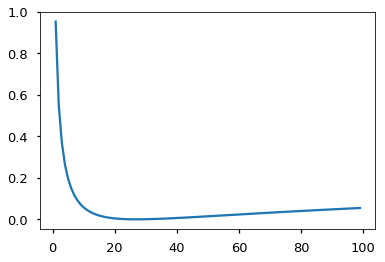

In [32]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x/d, 1/d, 1/d, 1/d],])
    return crit(Variable(predict.log()),
               Variable(torch.LongTensor([1]))).data[0]
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

### 实战：第一个例子
给定一个来自小词汇表的随机输入符号集，目标是生成相同的符号

### 合成数据

In [33]:
def data_gen(V, batch, nbatches):
    """ 生成一个随机数据用于 src-tgt复制任务"""
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad = False)
        tgt = Variable(data, requires_grad = False)
        yield Batch(src, tgt, 0)

### 损失计算

In [34]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)        
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                             y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data[0] * norm

### 贪心Decoding

In [47]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V,V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400, 
                    torch.optim.Adam(model.parameters(), lr=0, betas= (0.9, 0.98), eps = 1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, SimpleLossCompute(model.generator, criterion, None)))

Epoch Step: 1 Loss : 2.919252 Tokens per Sec: 632.587049 
Epoch Step: 1 Loss : 1.810452 Tokens per Sec: 972.720466 
1.8698960065841674
Epoch Step: 1 Loss : 1.919076 Tokens per Sec: 601.732985 
Epoch Step: 1 Loss : 1.705586 Tokens per Sec: 1224.252227 
1.6963751554489135
Epoch Step: 1 Loss : 1.787502 Tokens per Sec: 688.063315 
Epoch Step: 1 Loss : 1.268973 Tokens per Sec: 1231.309782 
1.2679367303848266
Epoch Step: 1 Loss : 1.745098 Tokens per Sec: 659.305915 
Epoch Step: 1 Loss : 1.070553 Tokens per Sec: 1086.663036 
1.0483794212341309
Epoch Step: 1 Loss : 1.513561 Tokens per Sec: 633.073115 
Epoch Step: 1 Loss : 0.914404 Tokens per Sec: 1092.527997 
0.9096437454223633
Epoch Step: 1 Loss : 0.974611 Tokens per Sec: 584.523709 
Epoch Step: 1 Loss : 0.584436 Tokens per Sec: 991.556454 
0.5504325270652771
Epoch Step: 1 Loss : 0.635267 Tokens per Sec: 580.220445 
Epoch Step: 1 Loss : 0.315016 Tokens per Sec: 1128.375105 


KeyboardInterrupt: 